In [2]:
import autoreload
from ray.tune.analysis import Analysis
import pandas as pd
import multiprocessing
from ap_rllib.make_video import make_video, parser
from ap_rllib.config import get_config_by_name
import ray
import shutil
from IPython.display import display, FileLink
from matplotlib import pyplot as plt
from ap_rllib_experiment_analysis.analysis_helpers import get_videos, get_scores, concat_videos, VideosDownloader, get_df_from_logdir
import numpy as np
import pickle
import os, json, re
from tqdm import tqdm
import gym_compete_rllib
from ap_rllib.config import get_trainer, get_config_by_name
import seaborn as sns

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
# need ray for parallel evaluation
ray.shutdown()
ray.init(num_cpus=28, ignore_reinit_error=True, log_to_driver=False)

2020-12-07 13:43:01,805	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '128.32.175.9',
 'raylet_ip_address': '128.32.175.9',
 'redis_address': '128.32.175.9:6379',
 'object_store_address': '/tmp/ray/session_2020-12-07_13-43-01_312798_30643/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-12-07_13-43-01_312798_30643/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2020-12-07_13-43-01_312798_30643',
 'metrics_export_port': 61857,
 'node_id': '68d8c5ace3297653781cc0366a4fa97445cafecf'}

In [4]:
# loading data
exp_name = "adversarial_tune_eval_sb"
config = "defense_eval_interactive_sb"
analysis = Analysis("/home/sergei/ray_results/" + exp_name)
df = analysis.dataframe(metric='policy_reward_mean/player_1', mode=None)

In [5]:
SCORE_STEPS = 1# 15
VIDEO_STEPS = 1# 15

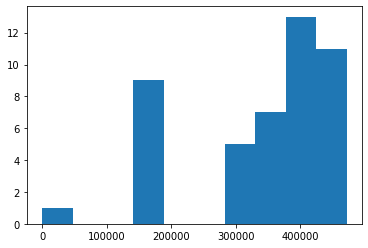

In [6]:
# removing short trials
plt.hist(df['episodes_total'])
df = df[df.episodes_total > 100000]

In [32]:
rdfs = {}
for i, trial in df.iterrows():
    rdfs[trial.trial_id] = get_df_from_logdir(trial.logdir)

100%|██████████| 2622/2622 [00:01<00:00, 1468.64it/s]


Trials ['2cfcb_00008', '2cfcb_00017']


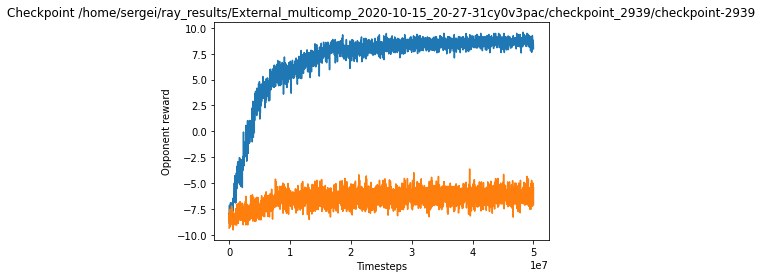

Trials ['2cfcb_00009', '2cfcb_00000']


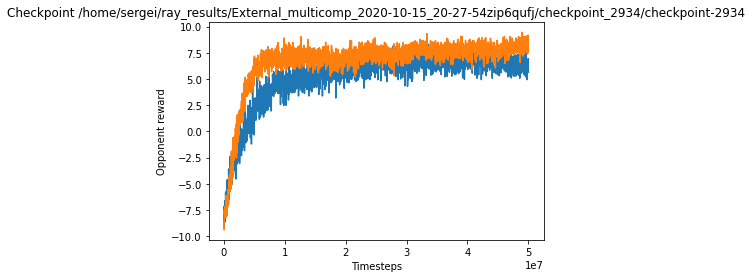

Trials ['2cfcb_00001', '2cfcb_00010']


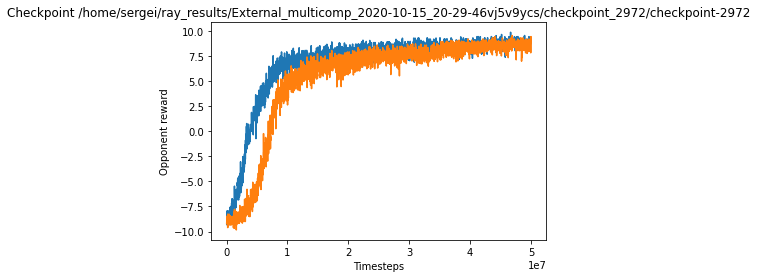

Trials ['2cfcb_00006', '2cfcb_00015']


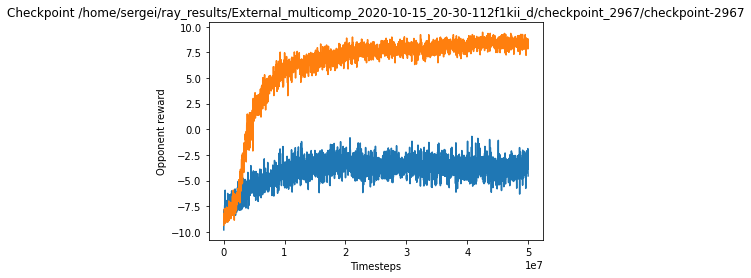

Trials ['2cfcb_00012', '2cfcb_00003']


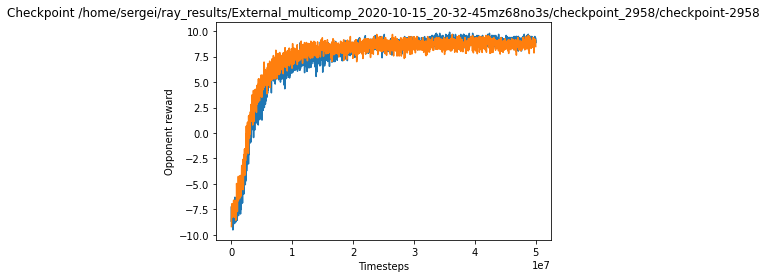

Trials ['2cfcb_00011', '2cfcb_00002']


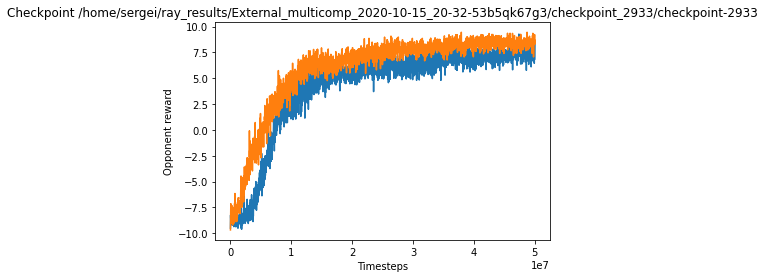

Trials ['2cfcb_00007', '2cfcb_00016']


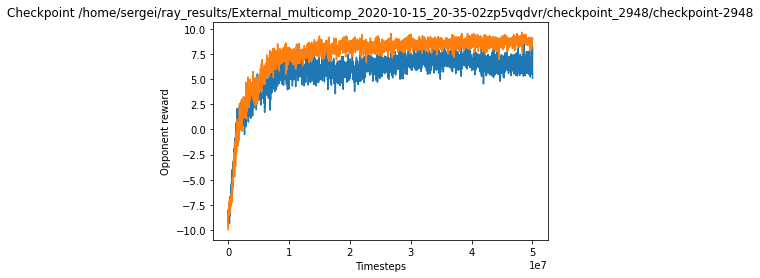

Trials ['2cfcb_00014', '2cfcb_00005']


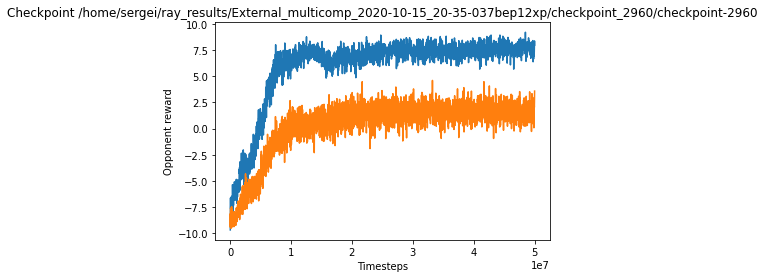

Trials ['2cfcb_00004', '2cfcb_00013']


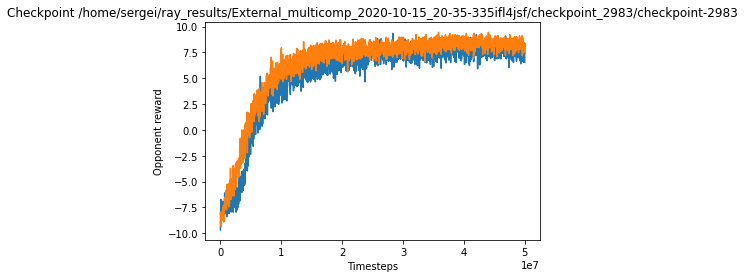

In [133]:
for _, df1 in df.groupby(['config/_checkpoint_restore']):
    plt.title(f"Checkpoint {df1.iloc[0]['config/_checkpoint_restore']}")
    plt.xlabel('Timesteps')
    plt.ylabel('Opponent reward')
    print("Trials", list(df1.trial_id))
    for trial in df1.trial_id:
        rdf = rdfs[trial]
        plt.plot(rdf['timesteps_total'], rdf['policy_reward_mean/player_1'])
    plt.show()

In [7]:
def fill_exponent_from_checkpoint_restore():
    """Add exponents field from the list of checkpoints."""
    exponents = []
    for _, row in df.iterrows():
        ckpt = row['config/_checkpoint_restore']
        params_path = os.path.join(os.path.split(os.path.split(ckpt)[0])[0], 'params.json')
        with open(params_path, 'r') as f:
            ckpt_config = json.loads(f.read())
        exponent = float(re.findall("'_burst_exponent': ([0-9\.]+)", ckpt_config['multiagent']['policy_mapping_fn'])[0])
        exponents.append(exponent)
    df['exponents'] = exponents

In [8]:
fill_exponent_from_checkpoint_restore()

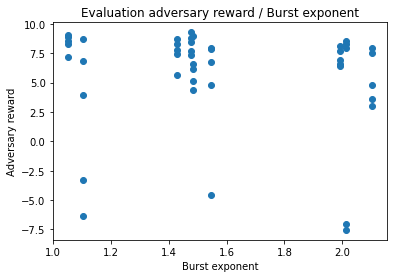

In [9]:
plt.title('Evaluation adversary reward / Burst exponent')
plt.xlabel('Burst exponent')
plt.ylabel('Adversary reward')
plt.scatter(df['exponents'], df['policy_reward_mean/player_1'])
plt.show()

In [ ]:
plt.title('Evaluation adversary reward / Burst exponent')
plt.xlabel('Burst exponent')
plt.ylabel('Adversary reward')
plt.scatter(df['exponents'], df['policy_reward_mean/player_1'])
plt.show()

In [114]:
config = 'external_test'

In [120]:
SCORE_STEPS = 15
VIDEO_STEPS = 3

In [121]:
scores = get_scores(df, steps=SCORE_STEPS, load_normal=False, config=config)
videos = get_videos(df, steps=VIDEO_STEPS, load_normal=False, config=config)

In [156]:
len(scores)

18

In [129]:
videos

['/scratch/sergei/better-adversarial-defenses/ap_rllib_experiment_analysis/video-20201031-123213-c708bf5e-1baf-11eb-8c5b-e0d55e6af99c/video.000000.mp4',
 '/scratch/sergei/better-adversarial-defenses/ap_rllib_experiment_analysis/video-20201031-123213-c706094e-1baf-11eb-8c5b-e0d55e6af99c/video.000000.mp4',
 '/scratch/sergei/better-adversarial-defenses/ap_rllib_experiment_analysis/video-20201031-123213-c709004a-1baf-11eb-8c5b-e0d55e6af99c/video.000000.mp4',
 '/scratch/sergei/better-adversarial-defenses/ap_rllib_experiment_analysis/video-20201031-123214-c74f794e-1baf-11eb-8c5b-e0d55e6af99c/video.000000.mp4',
 '/scratch/sergei/better-adversarial-defenses/ap_rllib_experiment_analysis/video-20201031-123214-c75b9d96-1baf-11eb-8c5b-e0d55e6af99c/video.000000.mp4',
 '/scratch/sergei/better-adversarial-defenses/ap_rllib_experiment_analysis/video-20201031-123214-c7a3eb28-1baf-11eb-8c5b-e0d55e6af99c/video.000000.mp4',
 '/scratch/sergei/better-adversarial-defenses/ap_rllib_experiment_analysis/video-2

In [131]:
with VideosDownloader() as vd:

    for i, trial in tqdm(df.iterrows()):
        video = videos[i]
        vd.add_video(video, f"exponent_{round(trial['exponents'], 2)}_trial_{trial.trial_id}.mp4")

18it [00:00, 305.91it/s]


/scratch/sergei/better-adversarial-defenses/ap_rllib_experiment_analysis/videos.zip

In [126]:
df['score_adv'] = [x['wins_policy_player_1_reward'] for x in scores]

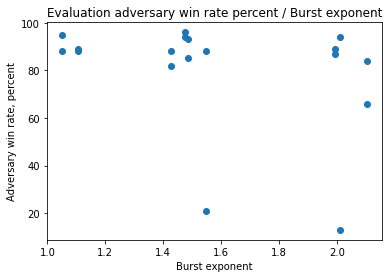

In [128]:
plt.title('Evaluation adversary win rate percent / Burst exponent')
plt.xlabel('Burst exponent')
plt.ylabel('Adversary win rate, percent')
plt.scatter(df['exponents'], df['score_adv'])
plt.show()

### Evaluating all policies against each other

In [10]:
config = 'external_test'
config_ = get_config_by_name(config)
config_['_verbose'] = False
config_['_policies'] = [None, 'pretrained', 'pretrained']
trainer_pretrained = get_trainer(config_)

2020-12-07 13:43:28,983	INFO trainer.py:589 -- Executing eagerly, with eager_tracing=False
2020-12-07 13:43:28,984	INFO trainer.py:1065 -- `_use_trajectory_view_api` only supported for PyTorch so far! Will run w/o.
2020-12-07 13:43:28,985	INFO trainer.py:619 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


Creating agent humanoid_blocker
Reading agent XML from: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Creating agent humanoid
Reading agent XML from: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Scene XML path: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/world_body.humanoid_body.humanoid_body.xml
Created Scene with agents
Creating agent humanoid_blocker
Reading agent XML from: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Creating agent humanoid
Reading agent XML from: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Scene XML path: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/world_body.humanoid_body.humanoid_body.xml
Create

2020-12-07 13:43:29,487	WARNING catalog.py:334 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!


Setting NN weights
Loading normalization
Setting NN weights
Loading normalization
It looks like variables ["<tf.Varaible player_1/param/std:0 shape=(380,) <dtype: 'float32'>>", "<tf.Varaible dense/kernel:0 shape=(380, 64) <dtype: 'float32'>>", "<tf.Varaible mean/kernel:0 shape=(64, 17) <dtype: 'float32'>>", "<tf.Varaible dense/bias:0 shape=(64,) <dtype: 'float32'>>", "<tf.Varaible mean/bias:0 shape=(17,) <dtype: 'float32'>>", "<tf.Varaible player_1/var/std:0 shape=(1, 17) <dtype: 'float32'>>", "<tf.Varaible player_1/param/clip:0 shape=(1,) <dtype: 'float32'>>", "<tf.Varaible player_1/sequential/value/kernel:0 shape=(64, 1) <dtype: 'float32'>>", "<tf.Varaible player_1/param/mean:0 shape=(380,) <dtype: 'float32'>>", "<tf.Varaible player_1/param/std:0 shape=(1,) <dtype: 'float32'>>", "<tf.Varaible player_1/sequential/h1/kernel:0 shape=(380, 64) <dtype: 'float32'>>", "<tf.Varaible player_1/sequential/h1/bias:0 shape=(64,) <dtype: 'float32'>>", "<tf.Varaible player_1/sequential/h2/kernel:0 

2020-12-07 13:43:29,802	WARNING catalog.py:334 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2020-12-07 13:43:29,904	WARNING util.py:40 -- Install gputil for GPU system monitoring.


Setting NN weights
Loading normalization
Setting NN weights
Loading normalization
It looks like variables ["<tf.Varaible player_2/sequential_2/value/bias:0 shape=(1,) <dtype: 'float32'>>", "<tf.Varaible player_2/sequential_2/h2/kernel:0 shape=(64, 64) <dtype: 'float32'>>", "<tf.Varaible player_2/sequential_2/h2/bias:0 shape=(64,) <dtype: 'float32'>>", "<tf.Varaible player_2/param/clip:0 shape=(1,) <dtype: 'float32'>>", "<tf.Varaible player_2/param/std:0 shape=(380,) <dtype: 'float32'>>", "<tf.Varaible player_2/sequential_2/h1/bias:0 shape=(64,) <dtype: 'float32'>>", "<tf.Varaible dense_5/kernel:0 shape=(64, 64) <dtype: 'float32'>>", "<tf.Varaible mean_2/kernel:0 shape=(64, 17) <dtype: 'float32'>>", "<tf.Varaible mean_2/bias:0 shape=(17,) <dtype: 'float32'>>", "<tf.Varaible player_2/param/mean:0 shape=(1,) <dtype: 'float32'>>", "<tf.Varaible player_2/sequential_2/value/kernel:0 shape=(64, 1) <dtype: 'float32'>>", "<tf.Varaible player_2/param/std:0 shape=(380,) <dtype: 'float32'>>", "<tf

In [11]:
config = 'external_test'
config_ = get_config_by_name(config)
config_['_verbose'] = False
trainer = get_trainer(config_)

Creating agent humanoid_blocker
Reading agent XML from: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Creating agent humanoid
Reading agent XML from: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Scene XML path: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/world_body.humanoid_body.humanoid_body.xml
Created Scene with agents


2020-12-07 13:43:30,102	WARNING catalog.py:334 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!


Creating agent humanoid_blocker
Reading agent XML from: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Creating agent humanoid
Reading agent XML from: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Scene XML path: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/world_body.humanoid_body.humanoid_body.xml
Created Scene with agents
Setting NN weights
Loading normalization
Setting NN weights
Loading normalization
It looks like variables ["<tf.Varaible player_1/sequential_4/h1/bias:0 shape=(64,) <dtype: 'float32'>>", "<tf.Varaible player_1/param/std:0 shape=(1,) <dtype: 'float32'>>", "<tf.Varaible dense_8/bias:0 shape=(64,) <dtype: 'float32'>>", "<tf.Varaible dense_8/kernel:0 shape=(380, 64) <dtype: 'float32'>>", "<tf.Varaible dense_9/kernel:0 shape=(64, 64) <dtype: 'float32'>>", "<tf.Varaible dense_9/bias:0 shape=

2020-12-07 13:43:30,348	WARNING catalog.py:334 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!


Setting NN weights
Loading normalization
Setting NN weights
Loading normalization
It looks like variables ["<tf.Varaible player_2/sequential_6/h2/kernel:0 shape=(64, 64) <dtype: 'float32'>>", "<tf.Varaible dense_12/kernel:0 shape=(380, 64) <dtype: 'float32'>>", "<tf.Varaible dense_13/kernel:0 shape=(64, 64) <dtype: 'float32'>>", "<tf.Varaible player_2/param/std:0 shape=(380,) <dtype: 'float32'>>", "<tf.Varaible player_2/param/std:0 shape=(380,) <dtype: 'float32'>>", "<tf.Varaible mean_6/kernel:0 shape=(64, 17) <dtype: 'float32'>>", "<tf.Varaible player_2/var/std:0 shape=(1, 17) <dtype: 'float32'>>", "<tf.Varaible player_2/param/std:0 shape=(1,) <dtype: 'float32'>>", "<tf.Varaible player_2/param/clip:0 shape=(1,) <dtype: 'float32'>>", "<tf.Varaible player_2/sequential_6/h2/bias:0 shape=(64,) <dtype: 'float32'>>", "<tf.Varaible player_2/sequential_6/value/kernel:0 shape=(64, 1) <dtype: 'float32'>>", "<tf.Varaible player_2/sequential_6/h1/bias:0 shape=(64,) <dtype: 'float32'>>", "<tf.Vara

2020-12-07 13:43:30,472	WARNING util.py:40 -- Install gputil for GPU system monitoring.


In [12]:
policies = trainer.get_weights().keys()

In [13]:
policies

dict_keys(['player_1', 'player_2'])

In [14]:
weights = {p: [] for p in policies}

for _, row in df.iterrows():
    ckpt = row.checkpoint_rllib
    trainer.restore(ckpt)
    for p, w in trainer.get_weights().items():
        weights[p].append(w)

2020-12-07 13:44:01,279	INFO trainable.py:482 -- Restored on 128.32.175.9 from checkpoint: /home/sergei/ray_results/External_multicomp_2020-10-28_07-24-36d572h2g5/checkpoint_2633/checkpoint-2633
2020-12-07 13:44:01,281	INFO trainable.py:489 -- Current state after restoring: {'_iteration': 2633, '_timesteps_total': None, '_time_total': 200047.52867126465, '_episodes_total': 472038}
2020-12-07 13:44:01,321	INFO trainable.py:482 -- Restored on 128.32.175.9 from checkpoint: /home/sergei/ray_results/External_multicomp_2020-10-30_02-08-11ia0_qn95/checkpoint_2609/checkpoint-2609
2020-12-07 13:44:01,322	INFO trainable.py:489 -- Current state after restoring: {'_iteration': 2609, '_timesteps_total': None, '_time_total': 136909.22732496262, '_episodes_total': 376636}
2020-12-07 13:44:01,348	INFO trainable.py:482 -- Restored on 128.32.175.9 from checkpoint: /home/sergei/ray_results/External_multicomp_2020-10-30_01-59-458ag4aj78/checkpoint_2629/checkpoint-2629
2020-12-07 13:44:01,349	INFO trainabl

In [15]:
for p, w in trainer_pretrained.get_weights().items():
    weights[p].append(w)

In [16]:
def weights_equal(w1, w2):
    """List of weights == another list of weights?"""
    assert len(w1) == len(w2)
    for a, b in zip(w1, w2):
        if not np.allclose(a, b):
            return False
    return True

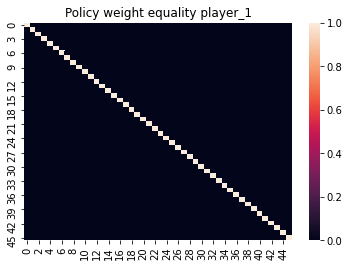

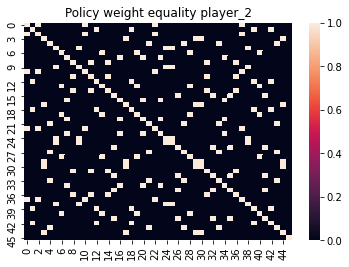

In [17]:
for p in policies:
    plt.title(f"Policy weight equality {p}")
    weq = [[weights_equal(x, y) for x in weights[p]] for y in weights[p]]
    sns.heatmap(weq)
    plt.show()

In [18]:
is_unique = {}
for p in policies:
    is_unique[p] = [not any([weights_equal(x, y) for j, y in enumerate(weights[p]) if j > i]) for i, x in enumerate(weights[p])]

In [19]:
print("Unique policies", {x: sum(y) for x, y in is_unique.items()})

Unique policies {'player_1': 46, 'player_2': 10}


In [20]:
print("Unique checkpoints restored", len(df['config/_checkpoint_restore'].unique()))

Unique checkpoints restored 9


In [21]:
import itertools
from uuid import uuid1

In [22]:
idxes = []

for w_pair in list(itertools.product(*[[(p, x) for x in range(len(w))] for p, w in weights.items()])):
    w_pair = dict(w_pair)
    valid_pair = True
    for p, idx in w_pair.items():
        if not is_unique[p][idx]:
            valid_pair = False
    if not valid_pair:
        continue
    
    idxes.append(w_pair)

In [23]:
for d in tqdm(idxes):
    trainer.set_weights({p: weights[p][d[p]] for p in policies})
    ckpt = trainer.save(f"/tmp/{uuid1()}")
    w_hash = sum([sum([np.sum(t) for t in y]) for y in trainer.get_weights().values()])
    d['checkpoint_rllib'] = ckpt
    d['hash'] = w_hash

100%|██████████| 460/460 [00:02<00:00, 192.43it/s]


In [24]:
hashes = [x['hash'] for x in idxes]

In [25]:
assert len(hashes) == len(set(hashes)), "Some pairs are the same"

In [26]:
fn = "/tmp/to_eval.csv"

In [27]:
df_to_eval = pd.DataFrame(idxes)
df_to_eval.to_csv(fn, index=False)

In [477]:
# run python -m ap_rllib_experiment_analysis.score_video_many --gin_config configs/score_make_video.gin --dataframe /tmp/to_eval.csv --score

In [31]:
df_to_eval

,player_1,player_2,checkpoint_rllib,hash
0,0,34,/tmp/63823c10-38d5-11eb-8c5f-e0d55e6af99c/chec...,4381.369831
1,0,36,/tmp/63823c11-38d5-11eb-8c5f-e0d55e6af99c/chec...,4367.817321
2,0,37,/tmp/63823c12-38d5-11eb-8c5f-e0d55e6af99c/chec...,4382.765925
3,0,38,/tmp/63823c13-38d5-11eb-8c5f-e0d55e6af99c/chec...,4389.006600
4,0,40,/tmp/63823c14-38d5-11eb-8c5f-e0d55e6af99c/chec...,4358.757821
...,...,...,...,...
455,45,41,/tmp/647d38a2-38d5-11eb-8c5f-e0d55e6af99c/chec...,4450.147018
456,45,42,/tmp/647d38a3-38d5-11eb-8c5f-e0d55e6af99c/chec...,4469.526201
457,45,43,/tmp/647d38a4-38d5-11eb-8c5f-e0d55e6af99c/chec...,4434.196636
458,45,44,/tmp/647d38a5-38d5-11eb-8c5f-e0d55e6af99c/chec...,4464.591859


In [41]:
from tqdm.auto import tqdm

In [44]:
for i, row in tqdm(df_to_eval.iterrows()):
    dir_to_copy = os.path.dirname(os.path.dirname(row.checkpoint_rllib))
#     print(dir_to_copy)
#     break
    !cp -r {dir_to_copy} /scratch/sergei/1adv_export/

In [ ]:
!zip -r ~/export_1adv_eval.zip /scratch/sergei/1adv_export/ {fn}

In [61]:
fn = "../../results/to_eval_all.csv"

df_to_eval = pd.read_csv(fn)

In [62]:
with open(fn + "_scores.json", 'r') as f:
    eval_data = json.load(f)
if len(eval_data) < len(df_to_eval):
     print("Warnin?g: not enough data", len(eval_data), len(df_to_eval))

In [63]:
len(eval_data) == len(df_to_eval)

True

In [64]:
df_to_eval

,player_1,player_2,checkpoint_rllib,hash
0,0,5000,/tmp/e72400bc-3961-11eb-85ce-1831bf455a80/chec...,4420.587047
1,0,5002,/tmp/e72400bd-3961-11eb-85ce-1831bf455a80/chec...,4389.690206
2,0,5003,/tmp/e72400be-3961-11eb-85ce-1831bf455a80/chec...,4372.916389
3,0,5004,/tmp/e72400bf-3961-11eb-85ce-1831bf455a80/chec...,4412.166457
4,0,5005,/tmp/e72400c0-3961-11eb-85ce-1831bf455a80/chec...,4418.325421
...,...,...,...,...
2327,5112,41,/tmp/faf8b9ff-3961-11eb-85ce-1831bf455a80/chec...,4451.015669
2328,5112,42,/tmp/faf8ba00-3961-11eb-85ce-1831bf455a80/chec...,4470.394853
2329,5112,43,/tmp/faf8ba01-3961-11eb-85ce-1831bf455a80/chec...,4435.065287
2330,5112,44,/tmp/faf8ba02-3961-11eb-85ce-1831bf455a80/chec...,4465.460510


In [65]:
for i, dta in enumerate(eval_data):
    for key, val in dta.items():
        if not (key.endswith('reward') or key == 'contacts_mean'): continue
#         print(i, key, val)
        df_to_eval.loc[i, key] = val

In [66]:
len(set(df_to_eval.checkpoint_rllib))

2332

/scratch/sergei/miniconda3/envs/adv-tf2/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


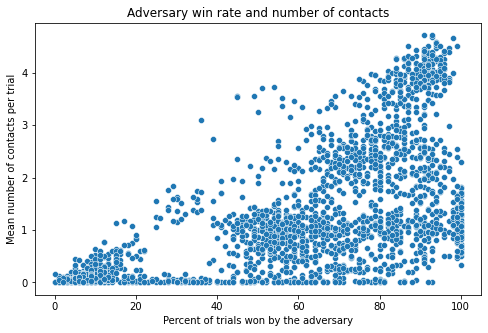

In [76]:
plt.figure(figsize=(8, 5))
plt.title("Adversary win rate and number of contacts")
sns.scatterplot(df_to_eval.wins_policy_player_1_reward, df_to_eval.contacts_mean)
plt.xlabel("Percent of trials won by the adversary")
plt.ylabel("Mean number of contacts per trial")
plt.show()

In [96]:
set(df_to_eval.player_2)

{34,
 36,
 37,
 38,
 40,
 41,
 42,
 43,
 44,
 45,
 5000,
 5002,
 5003,
 5004,
 5005,
 5006,
 5007,
 5008,
 5009,
 5010,
 5011,
 5012}

In [89]:
df_pivot = pd.pivot_table(df_to_eval, values='wins_policy_player_1_reward', index=['player_1'],
                    columns=['player_2'], aggfunc=np.sum)

In [103]:
df_pivot

,v34,v36,v37,v38,v40,v41,v42,v43,v44,v_normal,...,v5003,v5004,v5005,v5006,v5007,v5008,v5009,v5010,v5011,v5012
a00,91.0,92.0,94.0,87.0,89.0,92.0,93.0,88.0,94.0,89.0,...,89.0,90.0,86.0,97.0,83.0,73.0,86.0,100.0,88.0,79.0
a01,54.0,37.0,38.0,41.0,28.0,48.0,80.0,40.0,52.0,22.0,...,50.0,69.0,73.0,84.0,62.0,56.0,43.0,100.0,75.0,39.0
a02,95.0,94.0,97.0,90.0,98.0,97.0,95.0,92.0,95.0,93.0,...,82.0,82.0,93.0,90.0,84.0,76.0,81.0,99.0,90.0,74.0
a03,13.0,17.0,20.0,10.0,21.0,31.0,56.0,21.0,58.0,44.0,...,53.0,71.0,67.0,89.0,59.0,55.0,45.0,99.0,80.0,38.0
a04,92.0,92.0,96.0,96.0,90.0,93.0,92.0,93.0,94.0,92.0,...,77.0,75.0,83.0,93.0,68.0,72.0,82.0,100.0,90.0,68.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
a5508,6.0,8.0,8.0,3.0,11.0,8.0,6.0,11.0,12.0,0.0,...,48.0,65.0,67.0,85.0,59.0,47.0,62.0,99.0,79.0,54.0
a5509,12.0,8.0,12.0,7.0,12.0,10.0,6.0,6.0,10.0,4.0,...,61.0,72.0,72.0,86.0,64.0,58.0,53.0,96.0,85.0,53.0
a5510,12.0,7.0,12.0,6.0,9.0,7.0,9.0,9.0,13.0,3.0,...,53.0,57.0,73.0,89.0,51.0,62.0,44.0,100.0,79.0,52.0
a5511,12.0,9.0,7.0,8.0,6.0,6.0,10.0,11.0,14.0,3.0,...,67.0,66.0,76.0,84.0,58.0,50.0,58.0,100.0,80.0,55.0


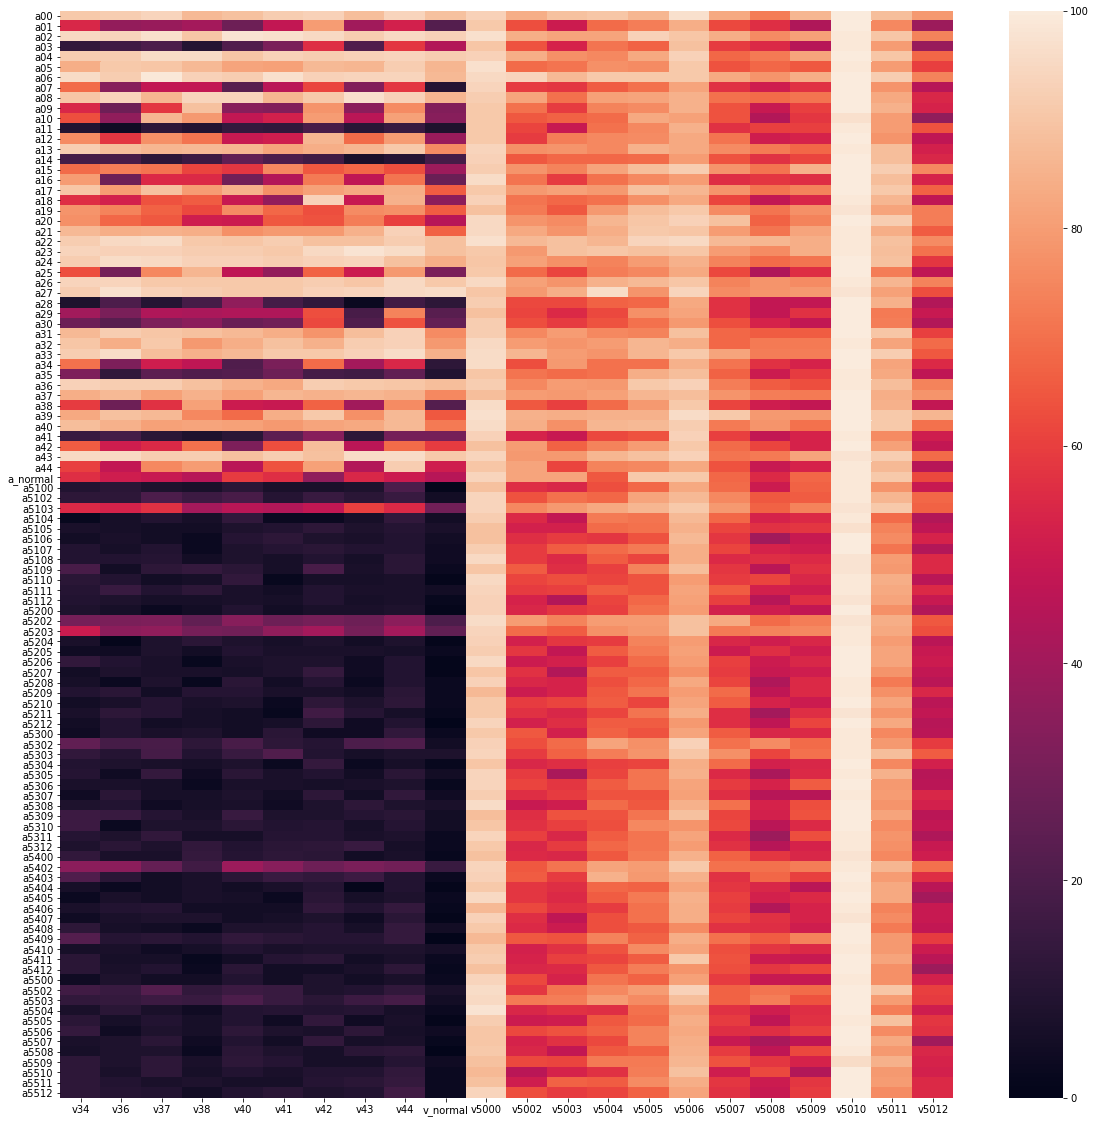

In [107]:
plt.figure(figsize=(20, 20))
sns.heatmap(df_pivot, xticklabels=df_pivot.columns, yticklabels=df_pivot.index)
plt.show()

In [101]:
df_pivot.columns[np.array(df_pivot).mean(axis=0).argmin()]

'v_normal'

In [102]:
df_pivot.index[np.array(df_pivot).mean(axis=1).argmax()]

'a06'

In [97]:
def victim_name(idx):
    if isinstance(idx, str): return idx
    if idx == 45:
        return "v_normal"
    return "v%02d" % idx

def adv_name(idx):
    if isinstance(idx, str): return idx
    if idx == 45:
        return "a_normal"
    return "a%02d" % idx

In [98]:
assert df_pivot.index.name == "player_1" # adversary
df_pivot.index = [adv_name(x) for x in df_pivot.index]

In [99]:
assert df_pivot.columns.name == "player_2" # victim
df_pivot.columns = [victim_name(x) for x in df_pivot.columns]

In [100]:
df_pivot.to_csv('../../results/pairs_win_rate_player_1_pbt_all.csv', index=True)

In [ ]:
d